# Demo 01 — Black–Scholes pricing and Greeks

This notebook demonstrates the **current public API** for:

- pricing European calls/puts under Black–Scholes
- computing analytic Greeks
- validating results with **put–call parity** and **finite-difference (FD)** Greeks
- sanity-checking behavior with a small **spot sweep**

> Tip: if you're running this notebook from the repository (not an installed package), the next cell adds `src/` to `sys.path` automatically.


In [1]:
from __future__ import annotations

import sys
from pathlib import Path


def _maybe_add_repo_src_to_path() -> None:
    here = Path().resolve()
    for parent in [here, *here.parents]:
        candidate = parent / "src" / "option_pricing"
        if candidate.exists():
            sys.path.insert(0, str(parent / "src"))
            return

_maybe_add_repo_src_to_path()


## Imports

In [10]:
from dataclasses import replace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from option_pricing.diagnostics.parity import put_call_parity_residual
from option_pricing.numerics.finite_diff import finite_diff_greeks
from option_pricing.pricers.black_scholes import (
    bs_greeks,
    bs_price_call,
    bs_price_put,
)
from option_pricing.types import MarketData, OptionSpec, OptionType, PricingInputs


## 1) Define a pricing scenario

In [11]:
# Market + contract setup (units: years for time, continuous compounding for rates)
market = MarketData(
    spot=100.0,
    rate=0.03,
    dividend_yield=0.01,
)

T = 1.0      # 1Y expiry
K = 100.0    # ATM strike
sigma = 0.20 # 20% vol

p_call = PricingInputs(
    spec=OptionSpec(kind=OptionType.CALL, strike=K, expiry=T),
    market=market,
    sigma=sigma,
    t=0.0,
)

p_put = PricingInputs(
    spec=OptionSpec(kind=OptionType.PUT, strike=K, expiry=T),
    market=market,
    sigma=sigma,
    t=0.0,
)

p_call


PricingInputs(spec=OptionSpec(kind=<OptionType.CALL: 'call'>, strike=100.0, expiry=1.0), market=MarketData(spot=100.0, rate=0.03, dividend_yield=0.01), sigma=0.2, t=0.0)

## 2) Price and analytic Greeks

In [12]:
call = bs_greeks(p_call)  # includes price + greeks
put = bs_greeks(p_put)

df = pd.DataFrame([call, put], index=["Call", "Put"])
df[["price", "delta", "gamma", "vega", "theta"]]


,price,delta,gamma,vega,theta
Call,8.827321,0.573496,0.019358,38.715175,-4.753690
Put,6.866891,-0.416554,0.019358,38.715175,-2.832403


## 3) Put–call parity check

In [ ]:
resid = put_call_parity_residual(call=call["price"], put=put["price"], p=p_call)

print(f"Put-call parity residual: {resid:.6e}")


Put–call parity residual: 0.000000e+00


## 4) Finite-difference validation (Greeks)

Finite differences are a quick sanity check: they should broadly agree with analytic Greeks
(up to discretization error from the bump sizes).


In [14]:
fd_call = finite_diff_greeks(p_call, price_fn=bs_price_call)
fd_put = finite_diff_greeks(p_put, price_fn=bs_price_put)

def _compare(analytic: dict[str, float], fd: dict[str, float]) -> pd.DataFrame:
    keys = ["price", "delta", "gamma", "vega", "theta"]
    out = pd.DataFrame(
        {
            "analytic": [analytic[k] for k in keys],
            "finite_diff": [fd[k] for k in keys],
        },
        index=keys,
    )
    out["abs_error"] = (out["finite_diff"] - out["analytic"]).abs()
    # relative error: avoid division by ~0 for gamma/theta in special regimes
    out["rel_error"] = out["abs_error"] / out["analytic"].abs().clip(lower=1e-12)
    return out

cmp_call = _compare(call, fd_call)
cmp_put = _compare(put, fd_put)

display(cmp_call)


,analytic,finite_diff,abs_error,rel_error
price,8.827321,8.827321,0.000000,0.000000e+00
delta,0.573496,0.573431,0.000064,1.124557e-04
gamma,0.019358,0.019355,0.000003,1.583272e-04
vega,38.715175,38.715150,0.000026,6.667163e-07
theta,-4.753690,-4.756610,0.002920,6.141849e-04


### Call vs FD: quick summary

In [15]:
cmp_call.style.format("{:.6g}")


,analytic,finite_diff,abs_error,rel_error
price,8.82732,8.82732,0,0
delta,0.573496,0.573431,6.44929e-05,0.000112456
gamma,0.0193576,0.0193545,3.06483e-06,0.000158327
vega,38.7152,38.7151,2.5812e-05,6.66716e-07
theta,-4.75369,-4.75661,0.00291964,0.000614185


## 5) Spot sweep: delta behavior

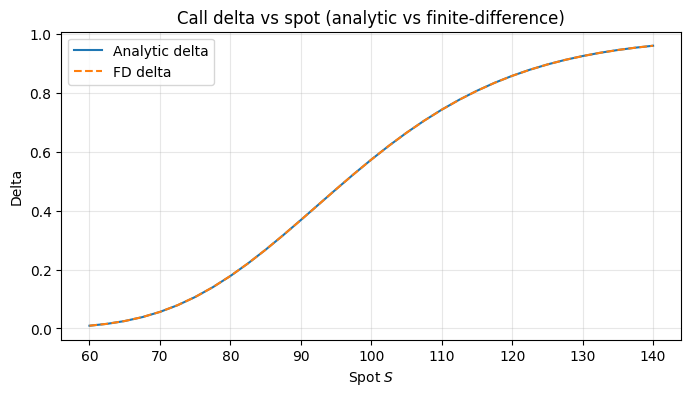

In [16]:
spots = np.linspace(60.0, 140.0, 33)

def with_spot(p: PricingInputs, spot: float) -> PricingInputs:
    return replace(p, market=replace(p.market, spot=float(spot)))

delta_analytic = []
delta_fd = []

for s in spots:
    pi = with_spot(p_call, s)
    delta_analytic.append(bs_greeks(pi)["delta"])
    delta_fd.append(finite_diff_greeks(pi, price_fn=bs_price_call)["delta"])

plt.figure(figsize=(8, 4))
plt.plot(spots, delta_analytic, label="Analytic delta")
plt.plot(spots, delta_fd, label="FD delta", linestyle="--")
plt.xlabel("Spot $S$")
plt.ylabel("Delta")
plt.title("Call delta vs spot (analytic vs finite-difference)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Takeaways

- `bs_price` and `bs_greeks` are the main entrypoints for European pricing under Black–Scholes.
- Put–call parity is a fast consistency check for call/put prices under the same inputs.
- Finite-difference Greeks provide a practical validation of the analytic formulas.
